## Вступление

###  Краткое описание проекта

Анализ крупного интернет-магазина. Необходимо приоритизировать гипотезы, составленные отделом маркетинга для увеличения выручки, а также проанализировать результаты A/B-теста и принять решение об окончании или продолжении теста и зафиксировать победу одной из групп A или B либо установить отсутствие различий между ними в случае принятия решения об окончании теста.

### Цель проекта

Принять решения, позволяющие увеличить выручку интернет-магазина на основе анализа результатов A/B-теста и приоритизации подготовленных гипотез с помощью фреймворков ICE и RICE.

### Описание данных

Данные о гипотезах hypothesis:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные о заказах orders:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Данные о количестве посетителей visitors:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

### План работы

В ходе исследования будет создано три датасета: hypothesis, orders и visitors. Будет  проведена  предобработка данных. Будут приоритизированы гипотезы из таблицы hypothesis с применением фреймворков ICE и RICE. Был проведен анализ A/B-теста, построены и проанализированы графики кумулятивной выручки, среднего чека, среднего количества заказов на пользователя по группам. Будут найдены 95 и 99 перцентили стоимости и количества заказов и выбрана граница для определения аномальных заказов. Юудет посчитана статистическая значимость различий в среднем количестве заказов на посетителя и в среднем чеке заказа между группами по "сырым" (без удаления аномалий) и "очищенным" (с удалением аномалий) данным. Были описаны результаты теста и принято решение продолжить или остановить тест, установить значимые различия между группами или их отсутсвие.

Этапы работы:
- загрузка и предобработка данных
- приоритизация гипотез
- анализ A/B-теста:
    - построение и анализ графиков среднего чека и среднего количества заказов по группам
    - нахождение перцентилей среднего чека и среднего количества заказов по группам
    - определение  статистической значимости различий в среднем чеке и в среднем количестве заказов с учётом аномалий и без
    - результаты теста и принятие решения
- выводы

## Загрузка и предобработка данных

In [1]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
dataframes = {
    'hypothesis': hypothesis, 
    'orders': orders, 
    'visitors': visitors
}

for name, df in dataframes.items():
    print('\033[1m' + f'Основная информация по таблице {name}' + '\033[0m')
    display(df.head(10))
    display(df.info())
    print(f'Кол-во пропусков в {name}: {df.isnull().sum().sum()}\n')
    print(f'Кол-во явных дубликатов в {name}: {df.duplicated().sum()}\n')

Основная информация по таблице hypothesis


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Кол-во пропусков в hypothesis: 0

Кол-во явных дубликатов в hypothesis: 0

Основная информация по таблице orders


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Кол-во пропусков в orders: 0

Кол-во явных дубликатов в orders: 0

Основная информация по таблице visitors


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Кол-во пропусков в visitors: 0

Кол-во явных дубликатов в visitors: 0



Пропусков и явных дубликатов в датасетах нет. Судя по увиденному, неявные дубликаты также отсутствуют.

In [4]:
hypothesis.columns = hypothesis.columns.str.lower() # поменяем заглавные буквы на строчные в названиях столбцов hypothesis
orders.columns = orders.columns.str.replace("I", "_i") # изменим стилистику названий столбцов на названия с нижним подчеркиванием

In [5]:
# приведем столбцы с датой к типу datetime

orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [6]:
# проверим, есть ли пересечения в группах A и B

ab_visitors = orders.groupby(by='visitor_id')['group'].agg(['nunique']).sort_values(by='nunique', ascending=False).reset_index()
ab_visitors = ab_visitors[ab_visitors['nunique'] != 1].sort_values(by='visitor_id')
display(ab_visitors)
print('Всего строк:', ab_visitors[ab_visitors['nunique'] != 1].shape[0])

,visitor_id,nunique
55,8300375,2
48,199603092,2
18,232979603,2
15,237748145,2
13,276558944,2
4,351125977,2
21,393266494,2
42,457167155,2
39,471551937,2
38,477780734,2


Всего строк: 58


58 пользователей находятся одновременно в двух группах: A и B. Удалим этих пользователей для дальнейшего анализа A/B-теста.

In [7]:
orders = orders[~orders['visitor_id'].isin(list(ab_visitors['visitor_id'].unique()))]
orders.groupby(by='visitor_id')['group'].agg(['nunique']).sort_values(by='nunique', ascending=False)

,nunique
visitor_id,
5114589,1
2908466434,1
2776274025,1
2785040378,1
2785527055,1
...,...
1426761187,1
1430210707,1
1438226485,1


Теперь в даннных остались только пользователи, принадлежащие к одной из групп.

In [8]:
print('Дата начала теста по orders:', str(orders['date'].min().date()))
print('Дата окончания теста по orders:', str(orders['date'].max().date()))
print('\nДата начала теста по visitors:', str(visitors['date'].min().date()))
print('Дата окончания теста по visitors:', str(visitors['date'].max().date()))

Дата начала теста по orders: 2019-08-01
Дата окончания теста по orders: 2019-08-31

Дата начала теста по visitors: 2019-08-01
Дата окончания теста по visitors: 2019-08-31


Тест проводился с 1 по 31 августа 2019 года. Данные по началу и концу теста совпадают для таблиц orders и visitors, значит, данные корректны.

### Выводы

1. Создано три датасета: hypothesis, orders и visitors. 
2. Датасеты проверены на пропуски, явные и неявные дубликаты. 
3. Стили заголовков столбцов были приведены к единому стилю: только строчные буквы, слова разделены нижними подчеркиваниями.
4. Столбцы с датой были приведены к типу datetime. 
5. Найдены пересечения в группах A и B. 58 пользователей, принадлежавшие к обеим группам, удалены.
6. Тест проводился с 1 по 31 августа 2019 года.

## Приоритизация гипотез

### Применение фреймворка ICE для приоритизации гипотез

In [9]:
hypothesis['ICE'] = (
    hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
).round(2)

pd.options.display.max_colwidth = 130
hypothesis.sort_values(by='ICE', ascending=False)\
    .style.set_properties(**{'text-align': 'left'})\
    .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.330000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.330000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.120000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


По методу ICE лучшими гипотезами стали:

№  | Гипотеза | ICE
:- | :------- | :--
8 | Запустить акцию, дающую скидку на товар в день рождения | 16.20
0 | Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей |  13.33
7 | Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок |  11.20

Показатель ICE для остальных гипотез равен 1-8.

### Применение фреймворка RICE для приоритизации гипотез

In [10]:
hypothesis['RICE'] = (
    hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
).round(2)

pd.options.display.max_colwidth = 130
hypothesis.sort_values(by='RICE', ascending=False)\
    .style.set_properties(**{'text-align': 'left'})\
    .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.330000,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.120000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.330000,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


По методу RICE лучшими гипотезами стали:

№  | Гипотеза | RICE
:- | :------- | :--
7  | Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок |  112
2  | Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа |  56
0  | Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей | 40
6  | Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию |  40

Показатель RICE для остальных гипотез равен 3-16,2.

### Сравнение приоритизации гипотез при применении RICE и ICE

RICE = ICE ∙ Reach

Метод RICE отличается от метода ICE тем, что учитывает компоненту Reach — количество пользователей, которых затронет изменение, которое мы хотим внести. Таким образом, после примерения фреймфорка RICE выше поднялись гипотезы, у которых бОльшее число пользователей будет затронуто (такие как гипотезы 7 и 2). В то же время гипотеза 8 опустилась с первого места на пятое, так как показатель Reach у неё равен 1, что очень мало.

### Выводы

1. По методу ICE лучшими гипотезами стали:
№	Гипотеза	ICE
8	Запустить акцию, дающую скидку на товар в день рождения	16.20
0	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	13.33
7	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	11.20
Показатель ICE для остальных гипотез равен 1-8.
2. По методу RICE лучшими гипотезами стали:
№	Гипотеза	RICE
7	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	112
2	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	56
0	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	40
6	Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	40
Показатель RICE для остальных гипотез равен 3-16,2.
3. Приоритизация гипотез при применении RICE вместо ICE подняла выше гипотезы с высоким показателем Reach (количество пользователей, которых затронет изменение, которое мы хотим внести) и опустила гипотезы с низким показателем Reach.

## Анализ A/B-теста

#### Сбор кумулятивных данных

In [11]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))  

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


In [12]:
# проверим, корректно ли создан датафрейм cummulativeData, сравним даты начала и окончания теста с исходными данными

print('Дата начала теста по cumulativeData:', str(cumulativeData['date'].min().date()))
print('Дата окончания теста по cumulativeData:', str(cumulativeData['date'].max().date()))

Дата начала теста по cumulativeData: 2019-08-01
Дата окончания теста по cumulativeData: 2019-08-31


Даты начала и окончания теста действительно совпадают с датами из исзодных датафреймов (1-31 августа 2019 года). Следовательно, датафрейм cumulativeData создан корректно.

### Кумулятивная выручка по группам

In [13]:
# функция для задания настроек последующим графикам

def plot_settings(title, ylabel, legend=False):
    plt.figure(figsize=(9,6))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Дата')
    plt.xticks(rotation=30)
    plt.grid(True)

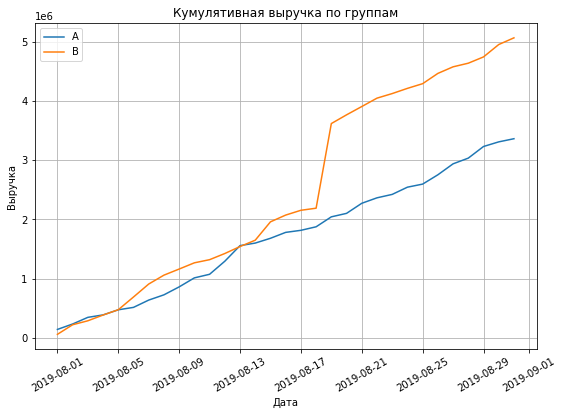

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plot_settings('Кумулятивная выручка по группам', 'Выручка')

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend();

На графике видно, что кумулятивная выручка по группе B стала приблизительно на 1,6-1,7 млн руб. выше, чем по группе A, начиная с 18-19 августа 2019 года и стабильно держит преимущество. До указанной даты различий между группами нет.

Есть вероятность, что такой резкий скачок получился из-за единичного дорогого заказа. Проверим эту теорию.

In [15]:
orders[orders['revenue'] > 100000]

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


Действительно, 19 августа была продажа на сумму 1 294 500 руб. в группе B. Если исключить эту продажу, кумулятивная выручка в группе B будет незначительно превышать выручку в группе A - приблизительно на 300-400 тыс. руб.

### Кумулятивный средний чек по группам

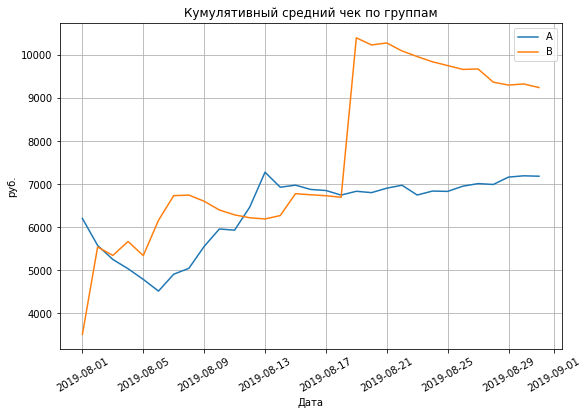

In [16]:
plot_settings('Кумулятивный средний чек по группам', 'руб.')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend();

По графику заметно преимущество значений кумулятивного среднего чека в группе B по сравнению с группой A, начиная с 18-19 августа 2019 года. Видно небольшое линейное снижение среднего чека группы B c 10,5 тыс. руб. 19 августа до 9,25 тыс. руб. на начало сентября. В период 19 августа - 1 сентября 2019 года средний чек группы B на 2-3 тыс. руб. больше среднего чека группы A.

### Относительное изменение кумулятивного среднего чека группы B к группе A

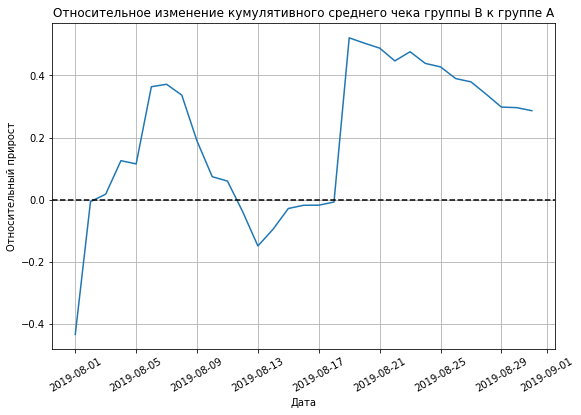

In [17]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plot_settings('Относительное изменение кумулятивного среднего чека группы B к группе A', 'Относительный прирост')

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

По графику относительного изменения кумулятивного среднего чека группы B к группе A видно два пика:
1. Резкий подъем относительного прироста показателей группы B к 7 августа 2019 года до почти 40% преимущества над группой A и далее такой же резкий спад к 13 августа до -15%.
2. Второй резкий подъем к 19 августа до 50% преимущества группы B над группой A и  последующее медленное линейное снижение к ё сентября до 30%.

### Кумулятивное среднее количество заказов на посетителя по группам

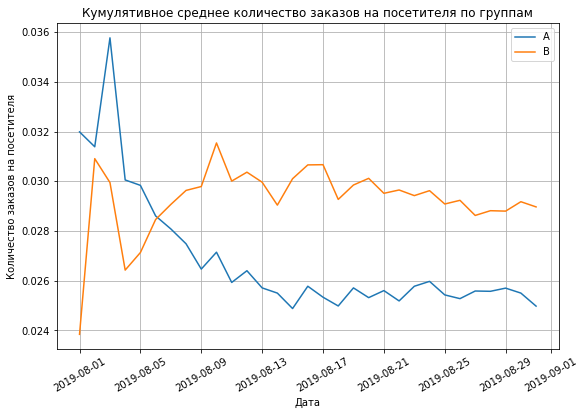

In [18]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plot_settings('Кумулятивное среднее количество заказов на посетителя по группам', 'Количество заказов на посетителя')

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.legend();

По графику кумулятивного среднего количества заказов на посетителя заметно устойчивое преимущество группы B над группой A  ,029 к 1 сентября 2019 года у группы B и 0,025 - у группы A). Преимущество стабильно сохраняется, начиная с 9 августа 2019 года.

### Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A

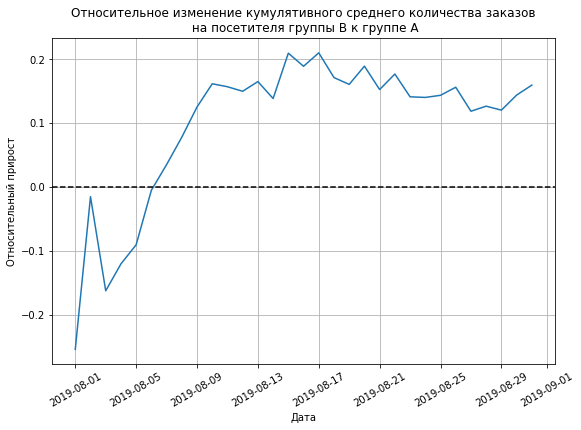

In [19]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plot_settings('Относительное изменение кумулятивного среднего количества заказов\n на посетителя группы B к группе A', 'Относительный прирост')

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--');

По графику относительного изменения кумулятивного среднего количества заказов на посетителя видны различия  в пользу группы B на
15-20%, начиная с 9 августа 2019 года.

### Точечный график количества заказов по пользователям

In [20]:
# подготовим данные для визуализации

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


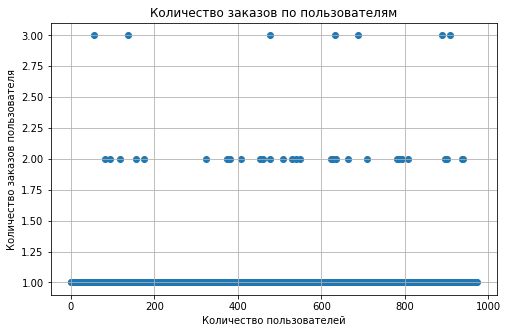

In [21]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(8, 5))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Количество заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов пользователя')
plt.grid(True);

Из точечного графика видно, что подавляющее большинство пользователей сделало всего 1 заказ, несколько пользователей сделало 2  заказа и всего 7 пользователей - 3 заказа. Более 3 заказов не сделал никто.

### 95-й и 99-й перцентили количества заказов на пользователя

In [22]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Не более 5% пользователей оформляли более 1 заказа. И 1% пользователей заказывали более 2 раз.

Выберем 2 заказа (99-й перцентиль) на одного пользователя за верхнюю границу числа заказов. Пользователи с числом заказов более 2 будут считаться аномальными.

### Точечный график стоимостей заказов

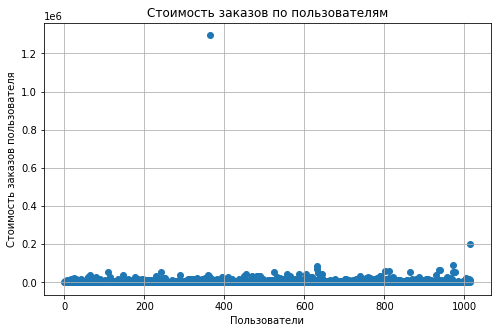

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(8, 5))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов пользователя')
plt.grid(True)

На данном графике можно увидеть всего 2 выброса, один из которых очень сильно отличается от основной массы данных (в 13 раз больше самых больших значений). График получился неинформативным. Обрежем график по оси y и выведем ещё раз.

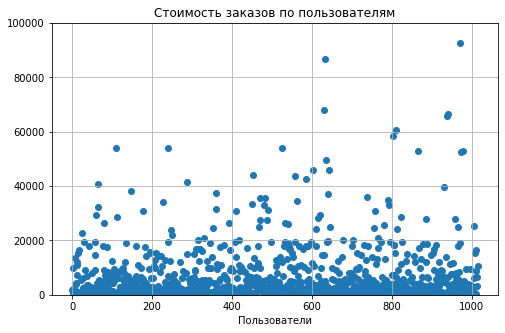

In [24]:
plt.figure(figsize=(8, 5))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Пользователи')
plt.grid(True)
plt.ylim([0, 100000]);

Помимо двух выбросов, найденных на предыдущем графике (1.3 и 0.2 млн руб), можно увидеть всего 5 заказов от 60 тыс. руб., небольшое кол-во заказов от 40 до 60 тыс. руб., бОльшее кол-во заказов (но всё равно заметно меньше, чем большинство) от 20 до 40 тыс. руб. и  очень много заказов от 0 до 20 тыс. руб.

### 95-й и 99-й перцентили стоимости заказов

In [25]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% заказов дороже 26 785 руб. и не более 1% дороже 53 904 руб.

Будем считать пользователей,  совершивших заказ более чем на 53 904 руб. (99-й перцентиль), аномальными.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. 

Нулевая: различий в среднем количестве заказов между группами нет. 

Альтернативная: различия в среднем между группами есть.

In [26]:
#подготовим данные

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

In [27]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Различие в средних между группами B и A: {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Различие в средних между группами B и A: 0.160


Вывод: по «сырым» данным различия в среднем количестве заказов на посетителя между группами есть.

P-value (0.011) меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 16%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. 

Нулевая: различий в среднем чеке между группами нет. 

Альтернативная: различия в среднем чеке между группами есть.

In [28]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Различие в средних между группами B и A: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.829
Различие в средних между группами B и A: 0.287


P-value (0.829) значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако, средний чек группы B выше среднего чека группы A на 28.7%, что довольно много. Вероятно, на такую большую разницу повлияли аномальные знамения. Проверим это утверждение чуть позже.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Мы приняли за аномальных пользователей, совершивших от 2 заказов (более 1), и/или сделавших заказ более чем на 40 тыс. руб. Сделав срез таким образом, мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.

In [29]:
# найдем количество аномальных пользователей

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 99)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 99)]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64
16


Всего 16 аномальных пользователей. 

In [30]:
# посмотрим, как аномальные пользователя повлияли на статистическую значимость различий в среднем количестве заказов между группами

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

# применим статистический критерий Манна-Уитни к полученным выборкам

print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Различие в средних между группами B и A: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.007
Различие в средних между группами B и A: 0.189


Результаты по среднему количеству заказов по "очищенным данным" близки к результатам теста по данным с аномалиями.

Различия между группами A и B есть. Выигрыш группы B составляет теперь 18,9% (по "сырым данным" было 16%).

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [31]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Различие в средних между группами B и A: {0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value: 0.788
Различие в средних между группами B и A: -0.032


P-value несильно изменился (0.788 по "очищенным  данным" и 0.829 по "сырым").
Статистически значимых различий в среднем чеке между группами нет.

Разница между сегментами изменилась с 28.7% на -3,2%. С удалением аномальных значений среднее по среднему чеку в группе A стало выше на 3,2%, чем в группе B. Такой большой спад произошёл из-за удаления того самого аномального чека на 1,3 млн руб. Однако, 3% - слишком маленькая разница, чтобы считать преимущество группы A значимым.

### Результаты теста (выводы)

1. Есть статистически значимое различие по среднему количеству заказов между группами и по "сырым", и по "очищенным" данным. Выигрыш группы B составляет 18,9% по данным без аномалий и 16% по данным с аномалиями.
2. Нет статистически значимого различия по среднему чеку между группами ни по "сырым", ни по данным после фильтрации аномалий. Разница между сегментами равна -3,2% по "очищенным данным" и 28.7% по данным с аномалиями между группами B и A соответственно.
3. График различия среднего количества заказов между группами сообщает, что результаты группы B стабильно лучше на 15%, чем результаты группы A, начиная с 9 августа 2019 года.
4. График различия среднего чека говорит о том, что результаты группы B лучше результатов группы А, начиная  примерно с 19 августа 2019 года. Однако, если в вышеуказанную дату результат группы B был лучше на 50%, то к сентябрю стал лучше только на  30%. Заметно линейное снижение относительного различия за указанное время.
5. Принято решение остановить тест, зафиксировать победу группы B, так как пользователи из группы B делают больше заказов (о чём свидетельствует статистическая значимость различий и график) и имеют такой же средний средний чек, как и пользователи из группы A.

## Вывод

В ходе исследования было создано три датасета: hypothesis, orders и visitors. Датасеты  были проверены на пропуски, явные и  неявные дубликаты. Стили заголовков столбцов были приведены к единому стилю: только строчные буквы, слова разделены нижними подчеркиваниями. Столбцы с датой были приведены к типу datetime. Были найдены пересечения в группах A и B. 58 пользователей, принадлежавшие к обеим группам, были удалены. Были приоритизированы гипотезы из таблицы hypothesis с применением фреймворков ICE и RICE и проведено сревнение приоритизации гипотез с использованием данных фреймворков, объяснены найденные различия. Был проведен анализ A/B-теста, в ходе которого были собраны кумулятивные данные, построены и проанализированы графики кумулятивной выручки по группам, кумулятивного среднего чека и среднего количества заказов на пользователя по группам, относительного изменения кумулятивного среднего чека и среднего количества заказов на пользователя по группам, точечный график стоимостей заказов. Были найдены 95 и 99 перцентили стоимости и количества заказов, по которым была выбрана граница для определения аномальных заказов. Была посчитана статистическая значимость различий в среднем количестве заказов на посетителя и в среднем чеке заказа между группами по "сырым" (без удаления аномалий) и "очищенным" (с удалением аномалий) данным. Были написаны  результаты теста и принято и объяснено решение по результатам теста.

1. 58 пользователей относились одновременно к обеим группам и были удалены.
2. По методу ICE лучшими гипотезами стали:

№  | Гипотеза | ICE
:- | :------- | :--
8 | Запустить акцию, дающую скидку на товар в день рождения | 16.20
0 | Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей |  13.33
7 | Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок |  11.20

3. По методу RICE лучшими гипотезами стали:

№  | Гипотеза | RICE
:- | :------- | :--
7  | Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок |  112
2  | Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа |  56
0  | Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей | 40
6  | Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию |  40

4. Кумулятивная выручка по группе B стала приблизительно на 1,6-1,7 млн руб. выше, чем по группе A, начиная с 18-19 августа 2019 года, и стабильно держит преимущество.
5. В период 19 августа - 1 сентября 2019 года средний чек группы B на 2-3 тыс. руб. больше среднего чека группы A (это на 30-50% больше, чем у группы A).
6. По графику относительного изменения кумулятивного среднего количества заказов на посетителя видны различия в пользу группы B на 15-20%, начиная с 9 августа 2019 года (0,29 заказов на одного пользователя в среднем к 1 сентября 2019 года у группы B и 0,025 - у группы A).
7. Подавляющее большинство пользователей сделало всего 1 заказ, несколько пользователей сделало 2 заказа и всего 7 пользователей - 3 заказа. Более 3 заказов не сделал никто.
8. Не более 5% пользователей оформляли более 1 заказа. И 1% пользователей заказывал более 2 раз.
9. Не более 5% заказов дороже 26 785 руб. и не более 1% дороже 53 904 руб.
10. За аномальных были приняты пользователя, совершившие от 2 заказов (более 1), и/или сделавшие заказ более чем на 40 тыс. руб.
11. Всего было найдено 16 аномальных пользователей.
12. Есть статистически значимое различие по среднему количеству заказов между группами и по "сырым", и по "очищенным" данным. Выигрыш группы B составляет 18,9% по данным без аномалий и 16% по данным с аномалиями.
13. Нет статистически значимого различия по среднему чеку между группами ни по "сырым", ни по данным после фильтрации аномалий. Разница между сегментами равна -3,2% по "очищенным данным" и 28.7% по данным с аномалиями между группами B и A соответственно.
14. Принято решение остановить тест, зафиксировать победу группы B, так как пользователи из группы B делают больше заказов (о чём свидетельствует статистическая значимость различий и график) и имеют такой же средний средний чек, как и пользователи из группы A.